## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [2]:
data_dir = './GTSR'
train_path = 'GTSR/Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

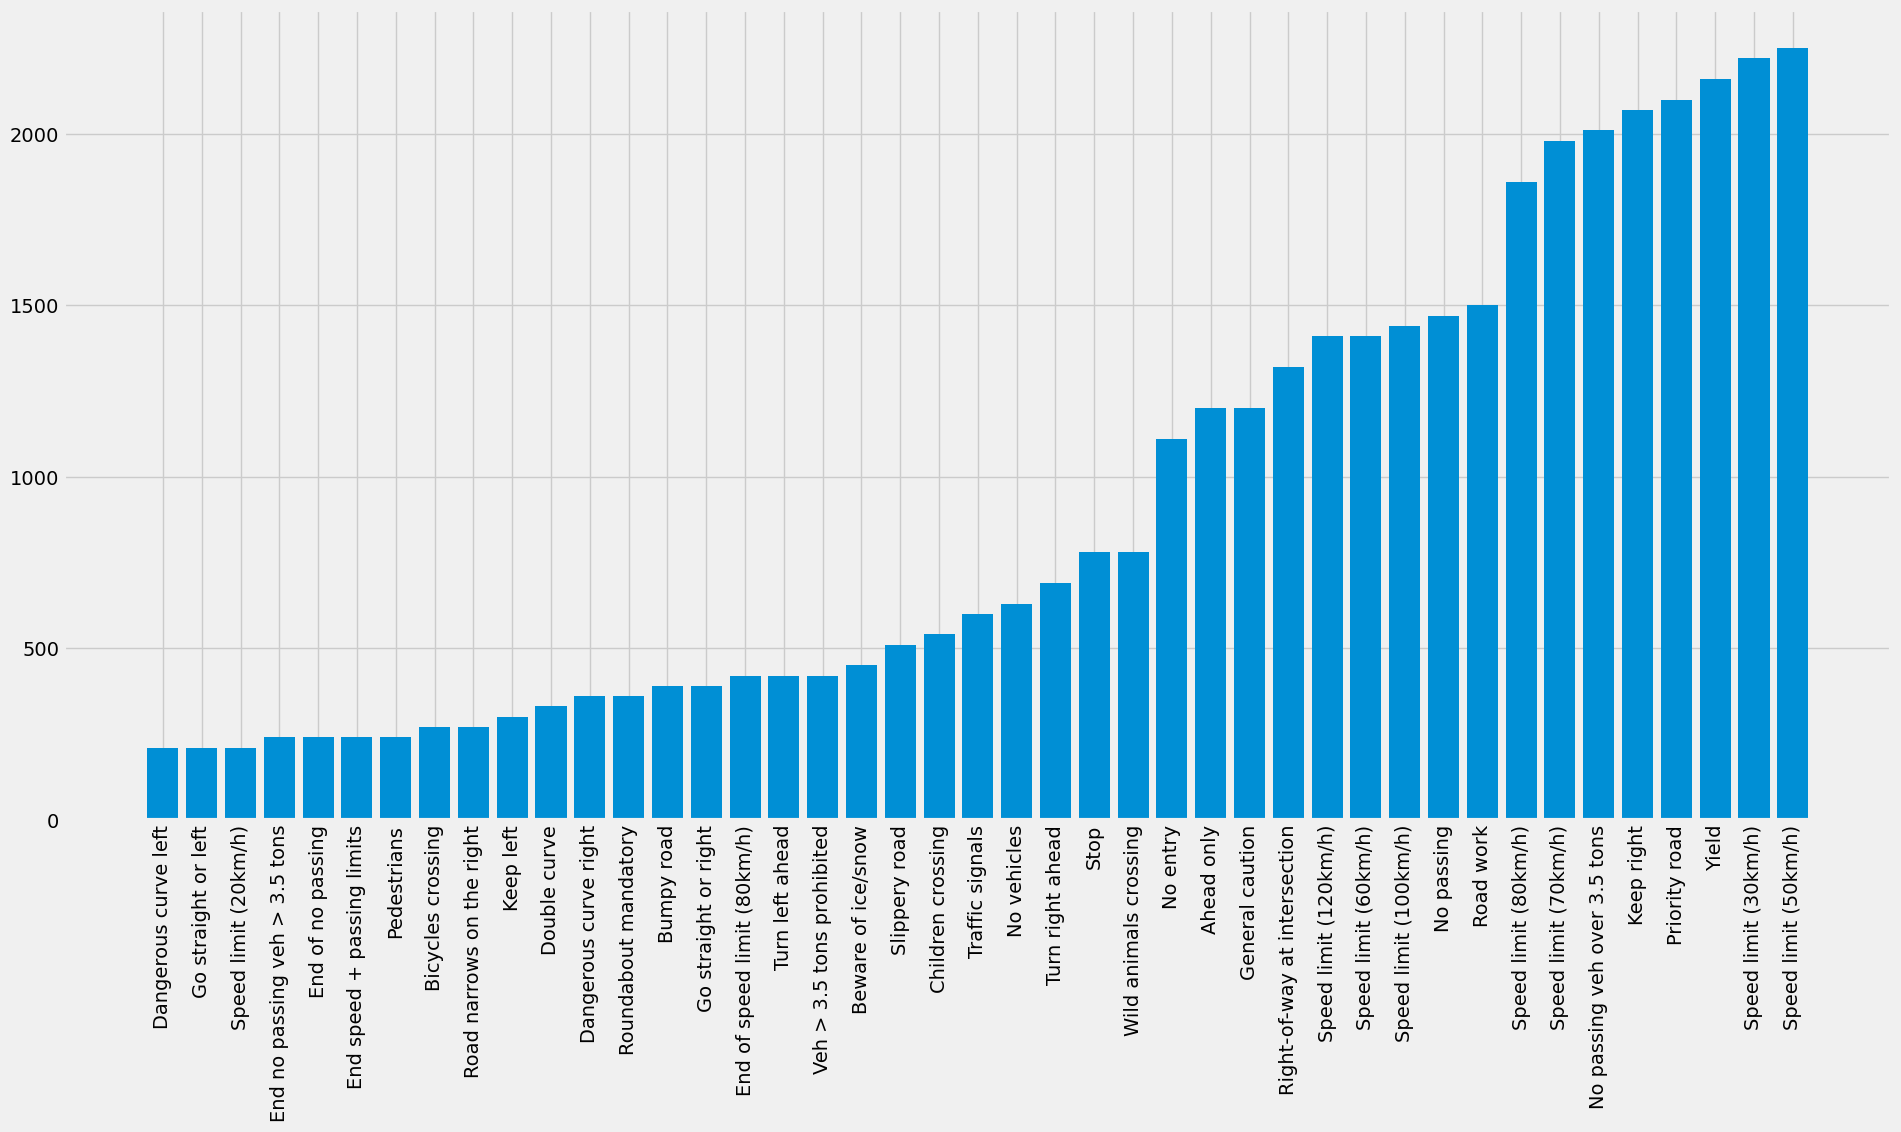

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

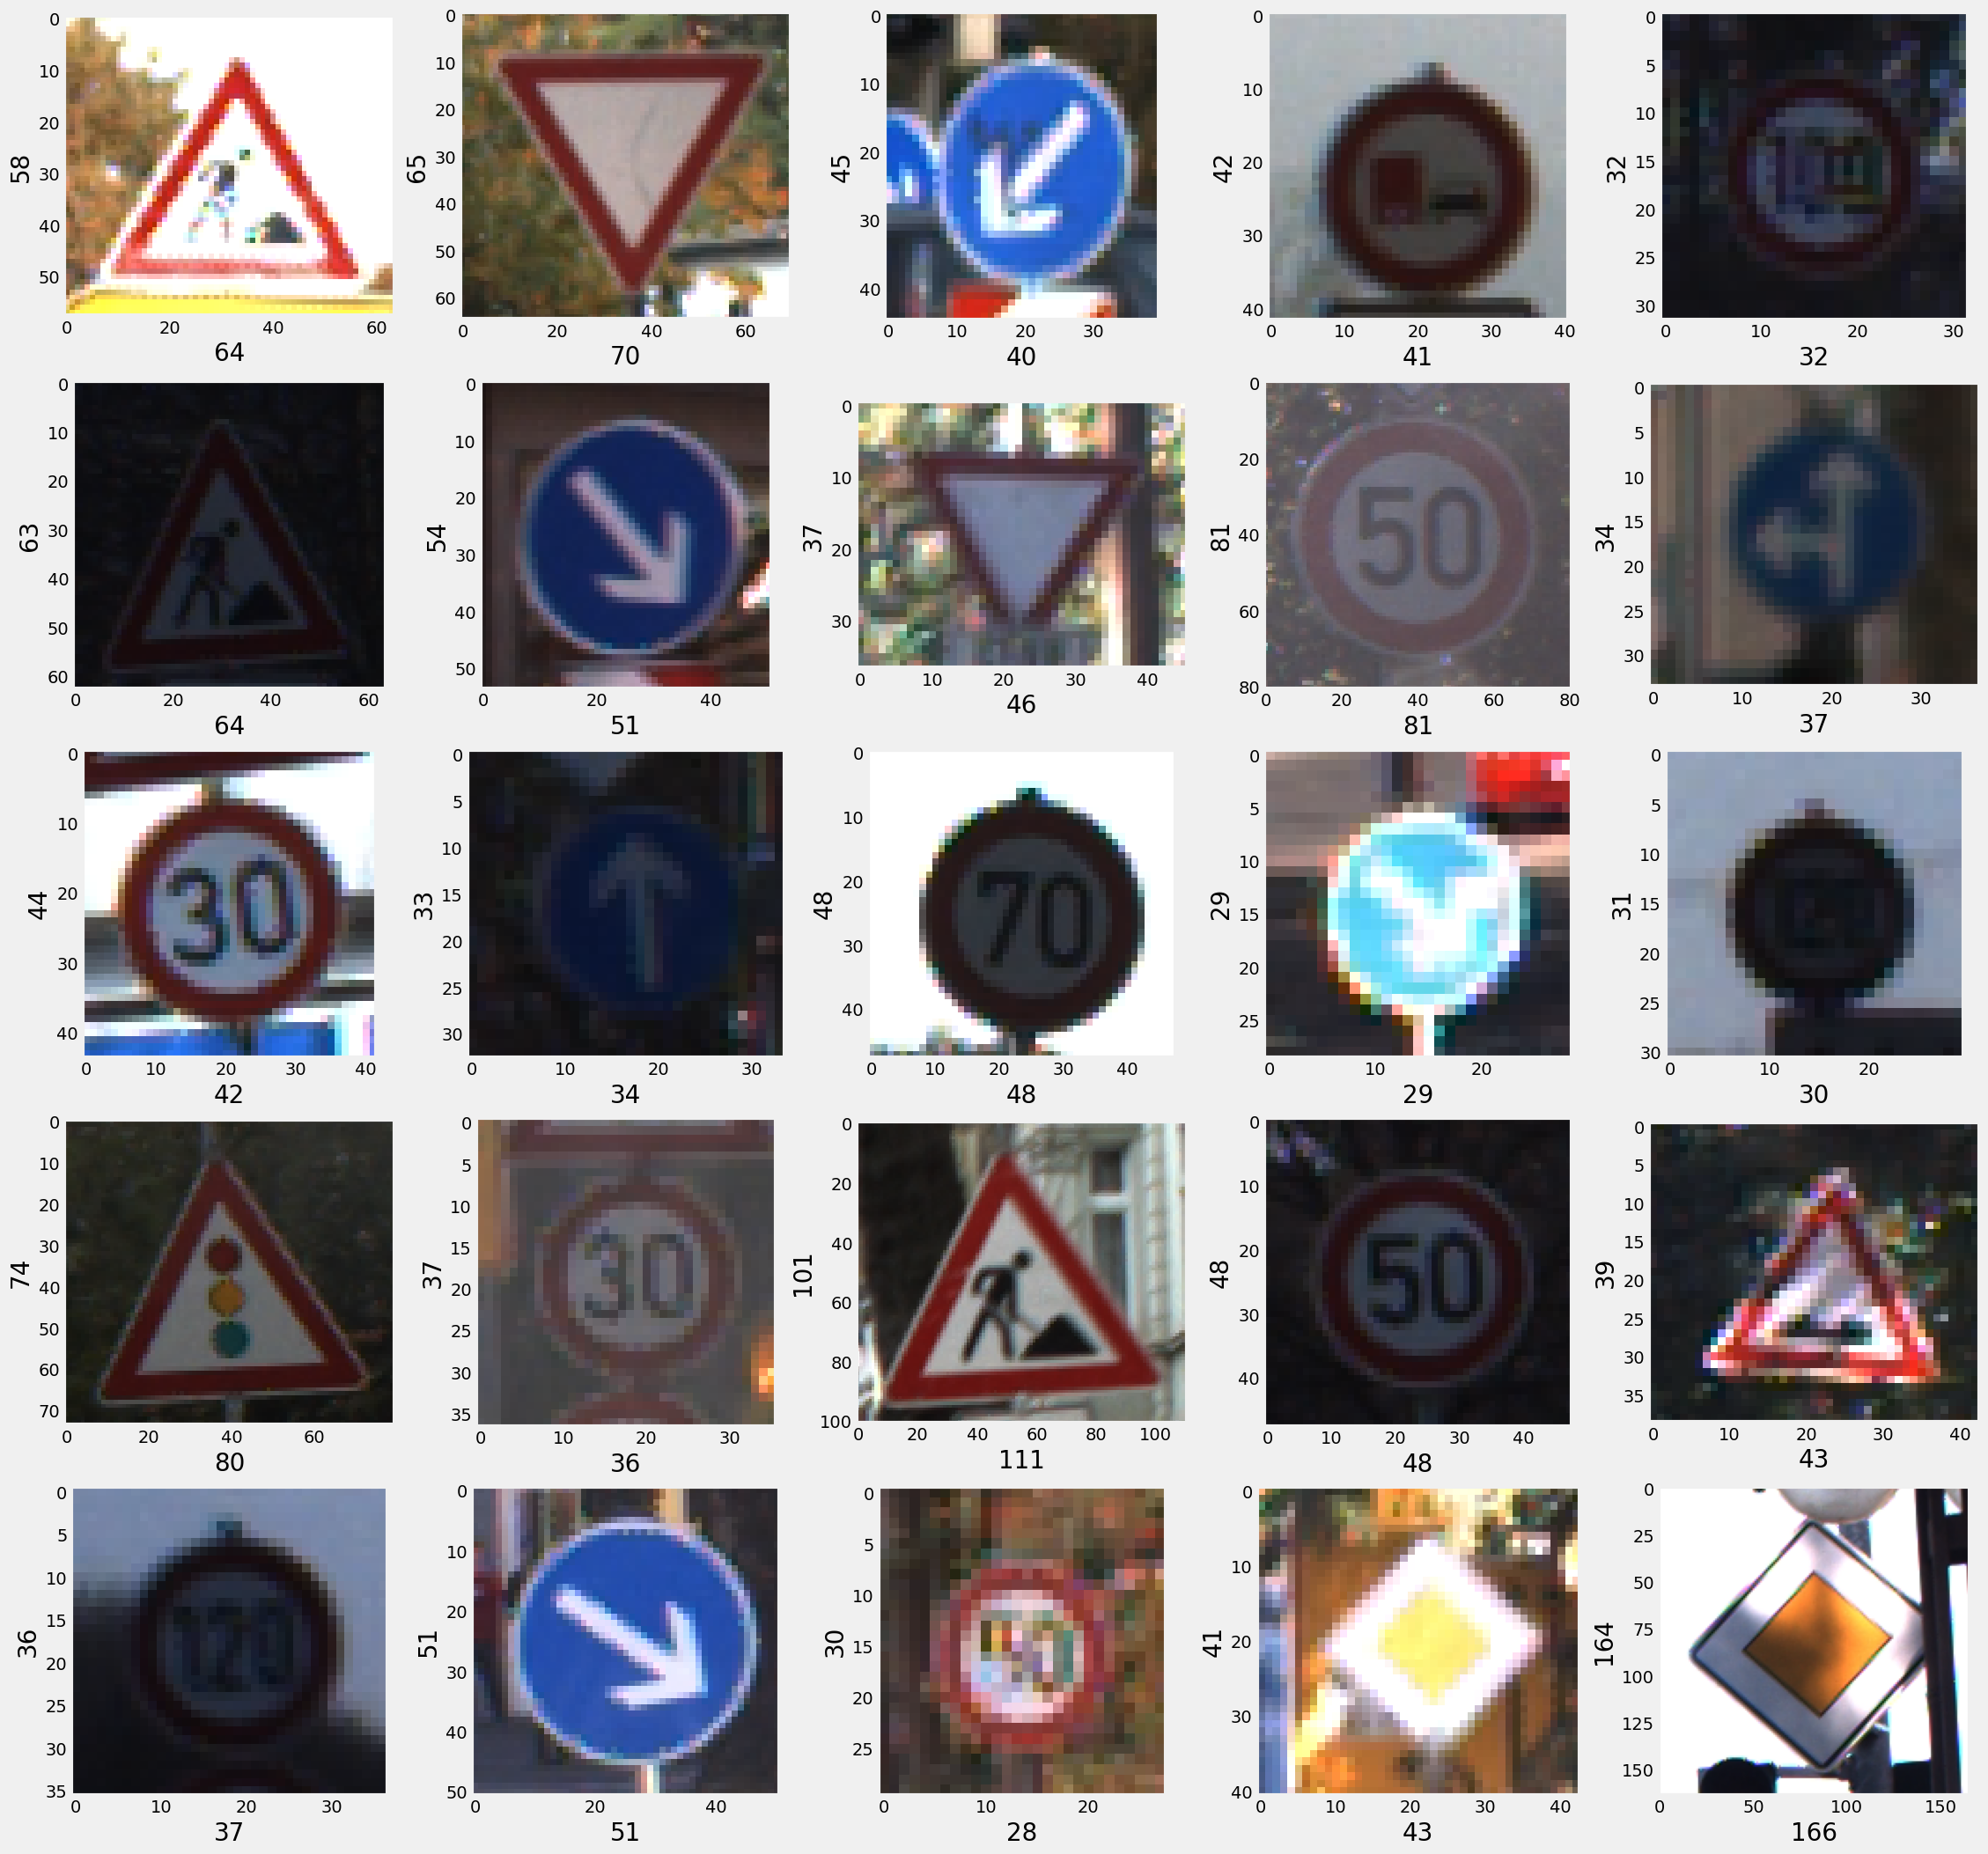

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [11]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,275 (4.47 MB)

 Trainable params: 1,169,931 (4.46 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [13]:
lr = 0.001
epochs = 30

# Use the recommended 'learning_rate' argument for Adam optimizer
opt = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - accuracy: 0.4994 - loss: 2.0319 - val_accuracy: 0.9743 - val_loss: 0.0806
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9397 - loss: 0.2041 - val_accuracy: 0.9868 - val_loss: 0.0429
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.9671 - loss: 0.1096 - val_accuracy: 0.9909 - val_loss: 0.0299
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9722 - loss: 0.0937 - val_accuracy: 0.9798 - val_loss: 0.0601
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9722 - loss: 0.0831 - val_accuracy: 0.9961 - val_loss: 0.0152
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9818 - loss: 0.0572 - val_accuracy: 0.9868 - val_loss: 0.0552
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 63ms/step - accuracy: 0.9822 - loss: 0.0598 - val_accuracy: 0.9964 - val_loss: 0.0117
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 63ms/step - accuracy: 0.9844 - loss: 0.0529 - val_accurac

## Evaluating the model

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []  # Initialize an empty list to store preprocessed images

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        if image is not None:  # Check if image is loaded successfully
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
        else:
            print(f"Error loading image: {img}")  # Informative error message
    except Exception as e:
        print(f"Error processing image {img}: {e}")  # More detailed error handling

X_test = np.array(data)
X_test = X_test / 255.0  # Normalize pixel values (division by 255.0)

# Assuming your model has a `predict` method (common in Keras models)
pred = model.predict(X_test)

# Get class labels from predictions (assuming model predicts class probabilities)
predicted_classes = np.argmax(pred, axis=1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, predicted_classes) * 100)

## Confusion matrix

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(22, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification report

In [ ]:
# Generate the classification report
class_report = classification_report(labels, predicted_classes, target_names=list(classes.values()))

print("Classification Report:")
print(class_report)

## Predictions on Test Data

In [ ]:
# Display some test images with their true and predicted labels
plt.figure(figsize=(20, 20))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_idx = random.randint(0, len(X_test) - 1)
    plt.imshow(X_test[random_idx])
    true_label = classes[labels[random_idx]]
    predicted_label = classes[predicted_classes[random_idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.show()

## Saving the model

In [ ]:
# Save the model
model.save('traffic_sign_recognizer.h5')

## Predicting on Custom Inputs

In [ ]:
# Display some test images with their true and predicted labels
plt.figure(figsize=(20, 20))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_idx = random.randint(0, len(X_test) - 1)
    plt.imshow(X_test[random_idx])
    true_label = classes[labels[random_idx]]
    predicted_label = classes[predicted_classes[random_idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.show()

In [ ]:
# Example usage:
image_path = './GTSR/Test/00036.png'
predicted_class = predict_image(image_path, loaded_model)
print(f'The predicted class for the image is: {predicted_class}')

In [ ]:
# Example usage:
image_path = './GTSR/Test/00057.png'
predicted_class = predict_image(image_path, loaded_model)
print(f'The predicted class for the image is: {predicted_class}')